# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle as pk
import numpy as np
import sklearn.manifold as man
from tensorflow.python.framework import ops

from model import Emoji2Vec, ModelParams
from phrase2vec import Phrase2Vec
from utils import build_kb, get_examples_from_kb, generate_embeddings, get_metrics

# Initializations
This step takes a while to execute, wait for 'DONE'

## Constants and Hyperparameters

In [2]:
word2vec_path = './data/word2vec/GoogleNews-vectors-negative300.bin'
mapping_path = 'emoji_mapping.p'
data_folder = './data/training/'
embeddings_file = 'generated_embeddings.p'

in_dim = 300   # Length of word2vec vectors
out_dim = 300  # Desired dimension of output vectors
pos_ex = 4
neg_ratio = 1
max_epochs = 40
dropout = 0.0

params = ModelParams(in_dim=in_dim, out_dim=out_dim, pos_ex=pos_ex, max_epochs=max_epochs,
                    neg_ratio=neg_ratio, learning_rate=0.001, dropout=dropout, class_threshold=0.5)


ckpt_path = params.model_folder('unicode') + '/model.ckpt'
e2v_path = params.model_folder('unicode') + '/emoji2vec.bin'
print(e2v_path)

./results/unicode/k-300_pos-4_rat-1_ep-40_dr-0/emoji2vec.bin


## Build Knowledge Base

In [3]:
print('reading training data from: ' + data_folder)
train_kb, ind2phr, ind2emoj = build_kb(data_folder)

pk.dump(ind2emoj, open(mapping_path, 'wb'))

reading training data from: ./data/training/


## Read or Generate Embeddings

In [4]:
embeddings_array = generate_embeddings(ind2phr=ind2phr, kb=train_kb, embeddings_file=embeddings_file,
                                             word2vec_file=word2vec_path)
print('DONE')

loading embeddings...
DONE


## Initialize models and mappings

In [5]:
print('Initializing: reading embedding data from: ' + word2vec_path)
# get the vector for a phrase
phraseVecModel = Phrase2Vec.from_word2vec_paths(params.in_dim, word2vec_path, e2v_path)
print('DONE')

Initializing: reading embedding data from: ./data/word2vec/GoogleNews-vectors-negative300.bin
DONE


In [6]:
ops.reset_default_graph()

# mapping from id to emoji
mapping = pk.load(open(mapping_path, 'rb'))
# mapping from emoji to id
inv_map = {v: k for k, v in mapping.items()}

# tensorflow model
model = Emoji2Vec(params, len(mapping), embeddings_array=embeddings_array)
print('DONE')

DONE


In [7]:
# initialize tensorflow session
session = tf.Session()
saver = tf.train.Saver()
saver.restore(session, ckpt_path)

# Performance Measures
Check the accuracy, f1 score, auc, and the auc graph

In [8]:
def measures(example_type):
    train_kb, ind2phr, ind2emoj = build_kb(data_folder)
    ex_set = get_examples_from_kb(kb=train_kb, example_type=example_type)

    # evaluate the dev. accuracy using this as the threshold
    thresh = 0.5

    acc = model.accuracy(session=session, dset=ex_set, threshold=thresh)
    f1 = model.f1_score(session=session, dset=ex_set)
    print(str.format('Accuracy at thresh={}: {}', thresh, f1))
    print(str.format('F1 score: {}', f1))
    
    try:
        auc = model.auc(session=session, dset=ex_set)


        print(str.format('AUC score: {}', auc))

        fpr, tpr, thresholds = model.roc_vals(session=session, dset=ex_set)

        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(fpr, tpr)
        ax.set_title("ROC Curve for learned emoji")
        plt.xlabel("false positive rate")
        plt.ylabel("true positive rate")

        #
        #for i , val in enumerate(thresholds):
        #    if i % 10 == 0:
        #        plt.annotate(val, (fpr[i], tpr[i]))

        plt.grid()
        plt.show()
    except:
        print('Can\'t compute AUC or ROC')

In [9]:
print('Train Set')
measures('train')

Train Set
Accuracy at thresh=0.5: 0.9933345343181408
F1 score: 0.9933345343181408
Can't compute AUC or ROC


Dev Set
Accuracy at thresh=0.5: 0.8
F1 score: 0.8
AUC score: 0.9160159999999999


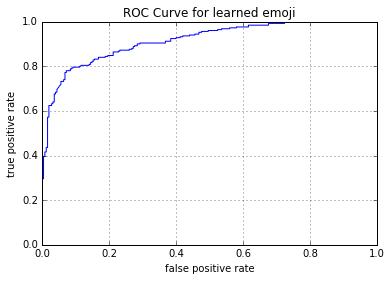

In [10]:
print('Dev Set')
measures('dev')

Test Set
Accuracy at thresh=0.5: 0.8362831858407079
F1 score: 0.8362831858407079
AUC score: 0.9308


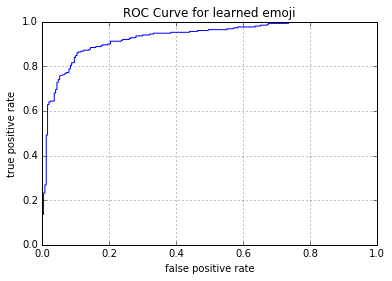

In [11]:
print('Test Set')
measures('test')

In [12]:
# RESET THE GRAPH
ops.reset_default_graph()
model = Emoji2Vec(params, len(mapping), embeddings_array=None, use_embeddings=False)

session = tf.Session()
saver = tf.train.Saver()
saver.restore(session, ckpt_path)

# Top Emoji Query
Set `phr` as a phrase, and get the top `N` emojis correlating to that phrase.

In [13]:
phr = 'happy face'
N = 5

# get the vector representaiton
vec = phraseVecModel[phr]

# query the tensorflow model
res = list()
for colIx in range(0, len(mapping)):
    predict = session.run(model.prob, feed_dict={
        model.col: np.array([colIx]),
        model.orig_vec: np.array([vec])
    })
    res.append(predict)

# print the top N emoji
for ind in sorted(range(len(res)), key=lambda i: res[i], reverse=True)[:N]:
    print(mapping[ind], res[ind])

😃 [ 0.964535]
😀 [ 0.96163309]
😊 [ 0.95175558]
☺️ [ 0.94744557]
😰 [ 0.86711448]


# Top Phrase Query
Set `em` as an emoji, and get the top `N` phrases correlating to that emoji.

In [14]:
# input
em = '👑'
N = 10

# get the relevant vectors from tensorflow
emoji_vecs = session.run(model.V)
vec = emoji_vecs[inv_map[em]]

# print top N phrases
for word, score in phraseVecModel.from_emoji([vec], top_n=N):
    print(str.format("{}\t{}", word, score))

queen	0.4512927532196045
king	0.4388968348503113
M.Kenseth_###-###	0.4338124394416809
----------_-----------------------------------------------_GS##	0.42637115716934204
E.Sadler_###-###	0.41635435819625854
J.McMurray_###-###	0.4102250337600708
Ky.Busch_##-###	0.4100269675254822
HuMax_IL8_TM	0.40330684185028076
T.Stewart_##-###	0.4017273485660553
K.Kahne_###-###	0.3957677483558655


# Analogy Task
Set `base` as a base emoji, `minus` as an emoji to subtract from the base, `plus` as an emoji to add, and get the top `N` correlating phrases and emojis relating to this analogy. 

In [15]:
def print_analogy_result(base, minus, plus):
    emoji_vecs = session.run(model.V)
    total = phraseVecModel[base] - phraseVecModel[minus] + phraseVecModel[plus]
    
    res = list()
    for colIx in range(0, len(mapping)):
        predict = session.run(model.prob, feed_dict={
            model.col: np.array([colIx]),
            model.orig_vec: np.array([total / np.linalg.norm(total)])
        })
        res.append(predict)
        
    ems = sorted(range(len(res)), key=lambda i: res[i], reverse=True)[:5]
    print(str.format('{} - {} + {} = {}', base, minus, plus, [mapping[em] for em in ems]))

In [16]:
print_analogy_result('👑', '🚹', '🚺')
print_analogy_result('💵', '🇺🇸', '🇬🇧')
print_analogy_result('💵', '🇺🇸', '🇪🇺')
print_analogy_result('👦', '👨', '👩')
print_analogy_result('👪', '👦', '👧')
print_analogy_result('🕶', '☀️', '⛈')

👑 - 🚹 + 🚺 = ['👸', '👑', '🏰', '💂', '🎎']
💵 - 🇺🇸 + 🇬🇧 = ['💵', '💷', '💶', '💴', '💲']
💵 - 🇺🇸 + 🇪🇺 = ['💵', '💶', '💴', '💷', '🏧']
👦 - 👨 + 👩 = ['👪', '👩', '👸', '🍼', '👵']
👪 - 👦 + 👧 = ['👪', '👭', '👸', '🚺', '🍼']
🕶 - ☀️ + ⛈ = ['⛈', '🌆', '👹', '🔍', '😟']


In [17]:
# input
base = '👑'
# base = '👨'
minus = '🚹'
plus = '🚺'
N = 10

# get the relevant vectors from tensorflow
emoji_vecs = session.run(model.V)
total = emoji_vecs[inv_map[base]] - emoji_vecs[inv_map[minus]] + emoji_vecs[inv_map[plus]]

# print the top N phrases
print(str.format('Top {} matching phrases:', N))
print()
for word, score in phraseVecModel.from_emoji([total], top_n=N):
    print(str.format("{}\t{}", word, score))
    
# query the tensorflow model
res = list()
for colIx in range(0, len(mapping)):
    predict = session.run(model.prob, feed_dict={
        model.col: np.array([colIx]),
        model.orig_vec: np.array([total / np.linalg.norm(total)])
    })
    res.append(predict)

# print the top N emoji
print()
print(str.format('Top {} matching emoji:', N))
print()
for ind in sorted(range(len(res)), key=lambda i: res[i], reverse=True)[:N]:
    print(mapping[ind], res[ind])

Top 10 matching phrases:

queen	0.4222303628921509
----------_-----------------------------------------------_GS##	0.37366756796836853
E.Sadler_###-###	0.3566628098487854
HuMax_IL8_TM	0.3483329117298126
By_BARRY_RUBIN	0.34455251693725586
M.Kenseth_###-###	0.33918794989585876
K.Kahne_###-###	0.3325173258781433
Ky.Busch_##-###	0.33232730627059937
J.McMurray_###-###	0.33023694157600403
T.Stewart_##-###	0.3282149136066437

Top 10 matching emoji:

👸 [ 0.99603832]
👑 [ 0.9942379]
🏰 [ 0.9935348]
💂 [ 0.97601867]
🚺 [ 0.97107917]
🎎 [ 0.96693647]
🏇 [ 0.96228433]
👪 [ 0.95918316]
🐞 [ 0.95408094]
🍮 [ 0.94833702]


# Visualize Emoji Vector Space
2-D projection of the Emoji vector space, using t-SNE.

Jupyter won't plot emoji. Use visualize.py to see a clearer picture.

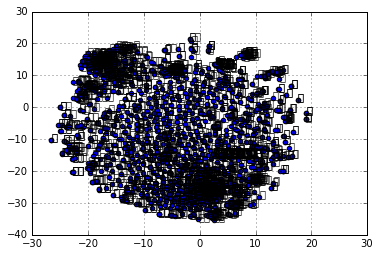

In [18]:
V = session.run(model.V)

fig = plt.figure()
ax = fig.add_subplot(111)
tsne = man.TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
trans = tsne.fit_transform(V)
x, y = zip(*trans)
plt.scatter(x, y)

for i in range(len(trans)):
    ax.annotate(mapping[i], xy=trans[i], textcoords='data')

plt.grid()
plt.show()